In [1]:
import os
import io
import re
import math
import torch
import pickle
import pandas as pd
from tqdm import tqdm

## Import Moss Data

In [54]:
folder_directory = '/Users/leonard.lee/Downloads/CS5340_Project/moss'
file_name = '1821_1935_2023.csv'

moss_folder = os.path.join(folder_directory, file_name)
moss_data = pd.read_csv(moss_folder)
moss_data.sample(10)

,mission,cohort1,assessment1,submission1,name1,cohort2,assessment2,submission2,name2,percent1,percent2,lines,url
4042,diagnostics,1821,33198,898629,ryan_casey,1821,33198,899528,russell_sutton,21,46,37,http://moss.stanford.edu/results/5/26685513583...
853,curve_manipulation,1935,38727,1049604,david_ruiz,2023,41898,1149857,sandra_thompson,48,51,22,http://moss.stanford.edu/results/6/28807170302...
1074,dna_translation,1935,39560,1089793,kara_medina,2023,41900,1204676,jennifer_li,58,59,46,http://moss.stanford.edu/results/5/39664034484...
2763,hungry_games_training_part_iii,1821,33181,943156,melanie_patrick,1821,33181,932857,linda_todd,25,15,14,http://moss.stanford.edu/results/1/54197889831...
2636,hungry_games_training_part_iii,1935,39738,1088171,kenneth_gross,1935,39738,1088074,mrs._mary_hammond,81,80,63,http://moss.stanford.edu/results/1/54197889831...
3698,curve_introduction,1935,38710,1041174,matthew_lang,1935,38710,1037140,adrian_pineda,96,96,37,http://moss.stanford.edu/results/2/43669032780...
2219,runic_paintings,1821,33171,867725,oscar_monroe,1821,33171,871809,vincent_adams,92,92,9,http://moss.stanford.edu/results/7/97114150793...
2130,runic_paintings,1935,38722,1011872,leah_brooks,1935,38722,1010622,latoya_mata,93,93,12,http://moss.stanford.edu/results/7/97114150793...
1509,kochize,1935,38718,1046906,tara_bonilla,2023,41928,1151042,tara_bonilla,98,98,30,http://moss.stanford.edu/results/5/72503962371...
2262,2048_solver,1821,33186,925753,cindy_howard,1935,38688,1075006,timothy_tucker,75,29,40,http://moss.stanford.edu/results/5/88293824866...


In [55]:
moss_data.shape

(4134, 13)

## **Task 1: Create Edge Weights**

The edge weight files produced:

1. Min
2. Max
3. Avg
4. Uniq_lines

In [56]:
## Remove self plagiarised students

moss_data = moss_data[moss_data['name1'] != moss_data['name2']]

In [57]:
## Produce sorted unique pairs of nodes (students)

unsorted_pairs = [(rows.name1, rows.name2) for _, rows in moss_data.iterrows() if rows.name1 != rows.name2] # Extract pairs
pairs = [] # Append only unique pairs
for pair in unsorted_pairs:
    a = (pair[0], pair[1])
    b = (pair[1], pair[0])
    if a in pairs or b in pairs:
        continue
    else:
        pairs.append(pair)

sorted_pairs = sorted(set(pairs), key=lambda x: x[0]) # Sort the pairs

In [58]:
## Create Dictionaries

all_names = set([i for pair in sorted_pairs for i in pair]) # Dictionary containing all_names
name_to_ID = {name: i for i, name in enumerate(sorted(all_names))} # Dictionary containing mapping from name to ID
ID_to_name = {i: name for i, name in enumerate(sorted(all_names))} # Dictionary containing mapping from ID to name
name_ID_dict = {'all_names': all_names, 'name_to_ID': name_to_ID, 'ID_to_name': ID_to_name} # Dictionary to save all dictionaries to pickle
test_index = 476
len(name_to_ID), ID_to_name[test_index], name_to_ID[ID_to_name[test_index]] ## Sanity Check

(1030, 'john_cuevas_md', 476)

In [59]:
## Save Dictionaries via pickle

# pickle.dump(name_ID_dict, open('name_id_dict.pkl', 'wb'))

In [60]:
## Get file lengths for uniq_lines edge weight files

def get_file_length(file_path, template_path):
    student_file = [line.strip() for line in io.open(file_path, 'r', encoding='utf-8') if line.strip() != '']
    template_file = [line.strip() for line in io.open(template_path, 'r', encoding='utf-8') if line.strip() != '']
    unique_lines = set(student_file).difference(set(template_file))
    return len(unique_lines)

lengths_dict = {'1821': {}, '1935': {}, '2023': {}} # Define dictionary to hold length info by cohort

folder = '/Users/leonard.lee/Downloads/CS5340_Project/global_moss' # Define folder_path
subfolders = moss_data['mission'].unique().tolist() # Extract Mission names that are mission folder names as well
for path in tqdm(subfolders):
    jpath = os.path.join(folder, path) # Join the paths
    files = os.listdir(jpath) # Get list of files in the mission folders
    for file in files:
        if file.split('.')[0] in ['1821', '1935', '2023']: # Extract those that are in selected cohorts
            batch = file.split('.')[0] # Get the file cohort name
            name = '.'.join(file.split('.')[3:-1]) # Get file student name
            leng = get_file_length(os.path.join(jpath, file), os.path.join(folder, 'templates/{}.py'.format(path))) # Get file length
            if path not in lengths_dict[batch]: # If new mission folder traversed, define new mission folder
                lengths_dict[batch][path] = {}
            lengths_dict[batch][path][name] = leng # Save length for student "name" in cohort "batch" and for mission submission "path"

100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


In [61]:
## Standardise two percentages and extract rank

method_name = 'uniq_lines' # Select standardizing method

def standardise_method(name, percent1, percent2, offending_lines, names, batch, mission, leng_dic):
    if name == 'min':
        return min(percent1, percent2)
    elif name == 'max':
        return max(percent1, percent2)
    elif name == 'avg':
        return (percent1+percent2)/2
    elif name == 'uniq_lines':
        try:
            denom = min(leng_dic[str(batch[0])][mission][names[0]], leng_dic[str(batch[1])][mission][names[1]])
            return offending_lines/denom
        except:
            print(batch, mission, names)
            return 0

moss_data['standardised1'] = moss_data.apply(
    lambda x: standardise_method(method_name, x['percent1'], x['percent2'], 
                                 x['lines'], (x['name1'], x['name2']), 
                                 (x['cohort1'], x['cohort2']), x['mission'],
                                 lengths_dict),
    axis=1
) # Obtain standardised scores between the two percentages "percent1" and "percent2"

pattern = re.compile(r'(match[0-9]+).html') # Pattern to extract ranks
moss_data['Moss Rank'] = moss_data['url'].apply(lambda x: int(pattern.search(x)[0][5:-5])) # Extract Ranks from URL

In [62]:
## Group and Rank by missions

grouped_moss_data = moss_data.groupby(["mission"]) # Group data by missions
max_rank = dict(zip(grouped_moss_data['Moss Rank'].max().index, grouped_moss_data['Moss Rank'].max())) # Get Max rank for that mission
mission_averages = grouped_moss_data['standardised1'].mean() # Obtain Mission standardised value averages
sorted_averages = sorted(zip(mission_averages.index, mission_averages), key=lambda x: x[1]) # Sort the averages
normalized_averages = dict(map(lambda x: (x[0], 1/x[1]), sorted_averages)) # Obtain normalized averages

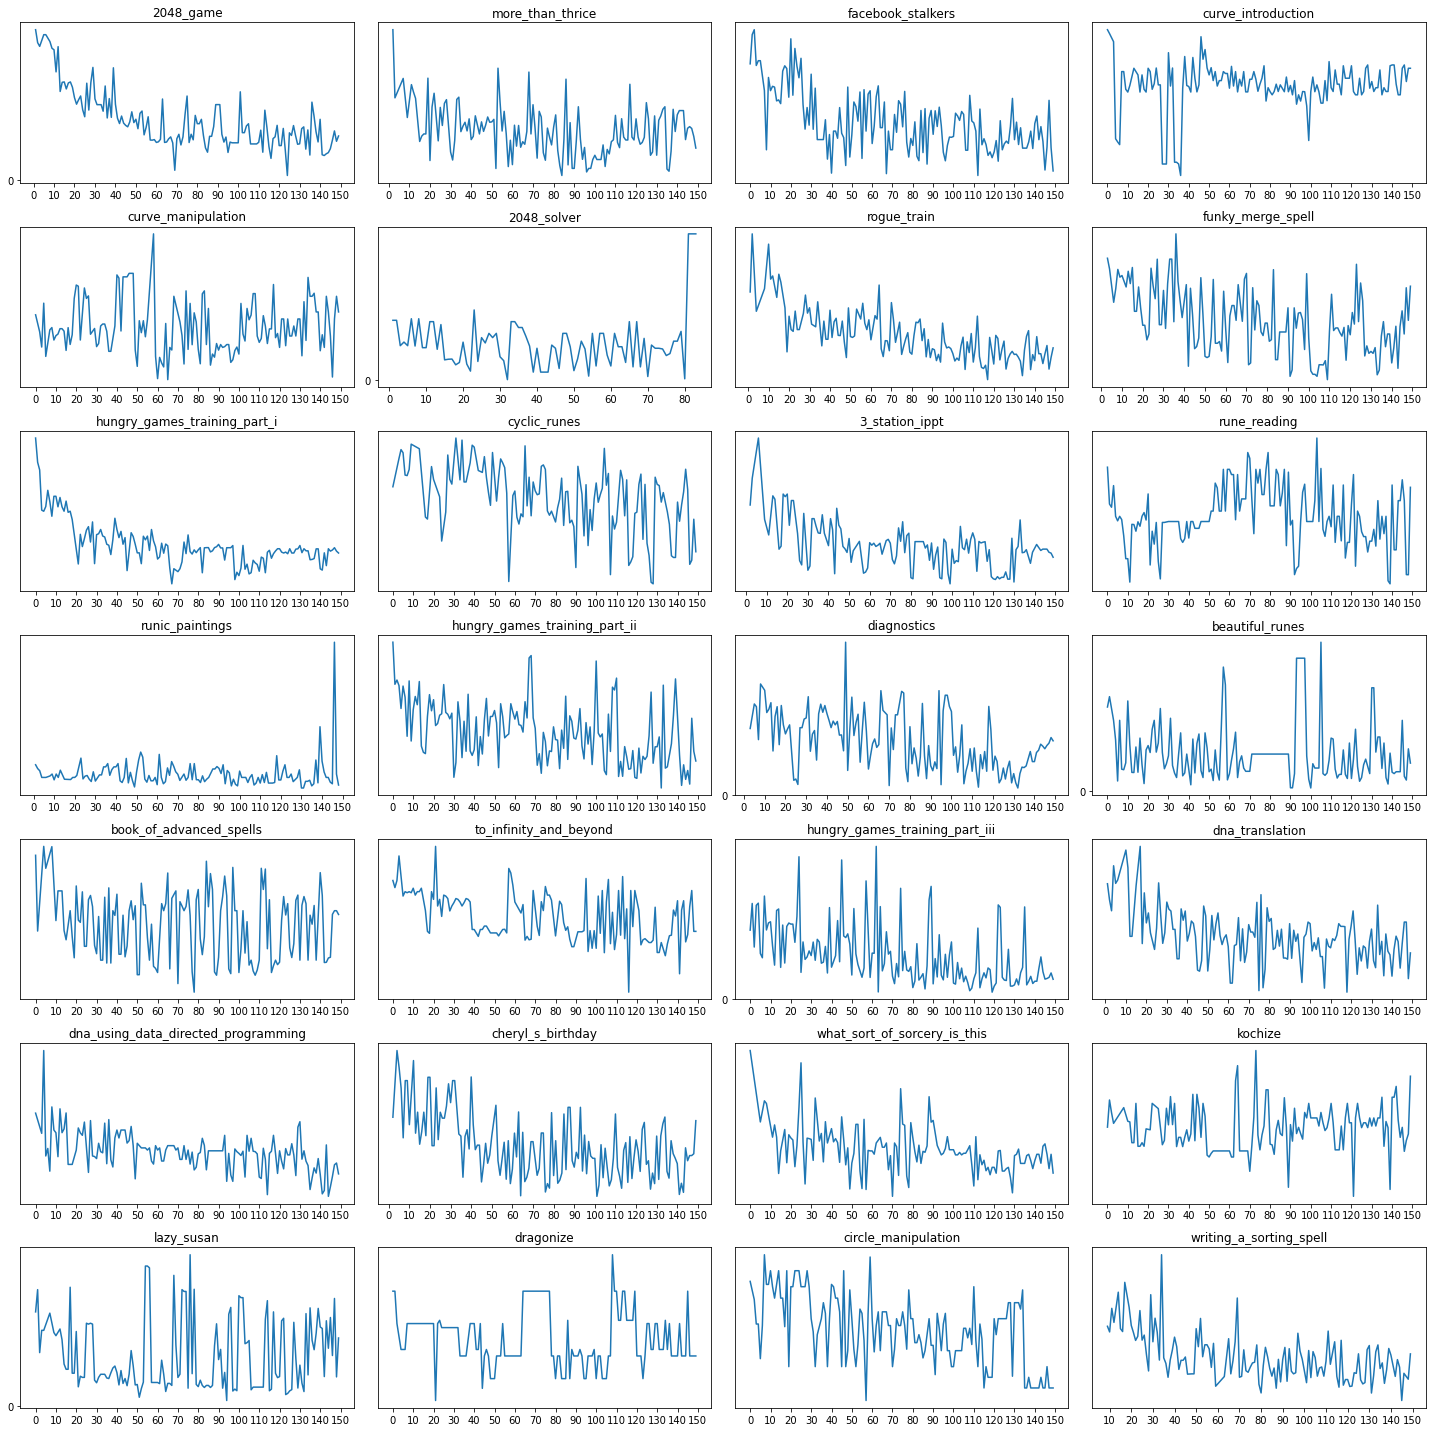

In [63]:
## Plot of Rank and Similarities

import numpy as np
import matplotlib.pyplot as plt

figure, ax = plt.subplots(nrows=7, ncols=4, figsize=[20, 20])
plt.setp(ax, xticks=[i for i in range(0, 151, 10)],
        yticks=[i for i in range(0, 101, 10)])
counter = 0
for name, group in grouped_moss_data:
    row, col = counter%7, counter%4
    x = np.array(group['Moss Rank'].tolist())
    y = np.array(group['standardised1'].tolist())
    ax[row, col].plot(x,y)
    ax[row, col].title.set_text('{}'.format(name))
    counter+=1
figure.tight_layout()
plt.savefig('rank_similarity_plots/{}_rank_vs_similarity_plot.png'.format(method_name))

In [64]:
## Slice points by MOSS Rank

def points_aggregation(moss_rank, max_rank, points):
    return math.exp(-(moss_rank)/max_rank)*points

def obtain_points(moss_rank, mission, mrank, raverages):
    _max_rank = mrank[mission]
    points = raverages[mission]
    return points_aggregation(moss_rank, _max_rank, points)

moss_data['Points'] = moss_data.apply(lambda x: obtain_points(x['Moss Rank'], x['mission'], max_rank, normalized_averages), axis=1)

In [65]:
percentile_pairs = {}
for pairs in tqdm(sorted_pairs):
    a = moss_data[(moss_data['name1'] == pairs[0]) & (moss_data['name2'] == pairs[1])]['Points'].sum()
    b = moss_data[(moss_data['name2'] == pairs[0]) & (moss_data['name1'] == pairs[1])]['Points'].sum()
    percentile_pairs[pairs] = a+b

100%|██████████| 3405/3405 [00:07<00:00, 462.05it/s]


In [66]:
## Export from pandas to CSV

export_data = pd.DataFrame([], columns=['NodeID1', 'NodeID2', 'edge_weights'])
for pair in tqdm(sorted_pairs):
    export_data=export_data.append({'NodeID1':pair[0], 'NodeID2':pair[1], 'edge_weights':percentile_pairs[pair]}, ignore_index=True)
    
# export_data.to_csv('{}_edge_weights.csv'.format(method_name), index=False)

100%|██████████| 3405/3405 [00:06<00:00, 495.03it/s]


In [67]:
export_data.head()

,NodeID1,NodeID2,edge_weights
0,aaron_christian,joseph_trevino,0.329899
1,aaron_christian,marc_key,0.476504
2,aaron_pope,carol_harris,0.419707
3,aaron_pope,annette_solis,0.347540
4,aaron_powell,pamela_gibbs,2.231531


In [68]:
len(set(export_data.NodeID1.tolist() + export_data.NodeID2.tolist())), len(set(list(map(lambda x: x[0], sorted_pairs)) + list(map(lambda x: x[1], sorted_pairs))))

(1030, 1030)

In [69]:
## Sanity Check for duplicate cases

dup_check = []

for pair in sorted_pairs:
    if pair[0] == pair[1]:
        print('Same pair alert: {}'.format(pair))
    elif (pair[1], pair[0]) in sorted_pairs:
        print('Non-unique pair alert: {}'.format(pair))
    elif pair in dup_check:
        print('Duplicate alert: {}'.format(pair))
        dup_check.append(pair)

In [70]:
## Sanity Check that the unique nodes are the same throughout

check_data = pd.read_csv('uniq_lines_edge_weights.csv')
a=set(check_data.NodeID1.tolist() + check_data.NodeID2.tolist())
a1=set([(row['NodeID1'], row['NodeID2']) for _, row in check_data.iterrows()])
check_data = pd.read_csv('min_edge_weights.csv')
b=set(check_data.NodeID1.tolist() + check_data.NodeID2.tolist())
b1=set([(row['NodeID1'], row['NodeID2']) for _, row in check_data.iterrows()])
check_data = pd.read_csv('max_edge_weights.csv')
c=set(check_data.NodeID1.tolist() + check_data.NodeID2.tolist())
c1=set([(row['NodeID1'], row['NodeID2']) for _, row in check_data.iterrows()])
check_data = pd.read_csv('avg_edge_weights.csv')
d=set(check_data.NodeID1.tolist() + check_data.NodeID2.tolist())
d1=set([(row['NodeID1'], row['NodeID2']) for _, row in check_data.iterrows()])
a == b, b == c, c == d, a1 == b1, b1 == c1, c1 == d1

(True, True, True, True, True, True)

In [106]:
for row in check_data.iterrows():
    print(row)
    break

(0, NodeID1         aaron_christian
NodeID2                marc_key
edge_weights           0.476504
Name: 0, dtype: object)


## Task 2 & 3: Synchronize Moss data and True Labels

In [23]:
folder_directory = '/Users/leonard.lee/Downloads/CS5340_Project/true_labels'
# file_name = '2023.csv'
# file_name = '1935.csv'
file_name = '1821.csv'

tl_folder = os.path.join(folder_directory, file_name)
tl_data = pd.read_csv(tl_folder)
tl_data.head()

In [25]:
## Task 2 & 3 (Check Moss Results)

def checker(name):
    if name in name_to_ID.keys():
        return name_to_ID[name]
    return 'Name Not Found Error'

labels = tl_data[['Name', 'Please indicate the assignments']]
labels['ID'] = labels['Name'].apply(lambda x: checker(x))
names_not_found = labels[labels['ID'] == 'Name Not Found Error']
names_found = labels[labels['ID'] != 'Name Not Found Error']

/Users/leonard.lee/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
labels.head(n=30)

In [93]:
names_not_found

,Name,Please indicate the assignments,ID
4,steven_campbell,"curve_introduction,curve_manipulation,rogue_train",Name Not Found Error
36,eric_ford,3_station_ippt,Name Not Found Error


In [94]:
names_not_found.to_csv('missing_names/missing_names_'+file_name, index=False)

In [ ]:
names_found

In [13]:
all_labels = pd.DataFrame([])

In [26]:
all_labels = all_labels.append(names_found)

In [27]:
all_labels.shape

(163, 3)

In [28]:
all_labels.head()

,Name,Please indicate the assignments,ID
0,jeff_hines,"runic_painting,magic_efficiency,curve_introduc...",411
1,meagan_boyle,"rogue_train,to_infinity_and_beyond",686
2,timothy_francis,rogue_train,976
3,johnathan_velazquez,"lazy_susan,3_station_ippt",485
5,gary_brooks,rogue_train,325


## Task 4: NetworkX

In [38]:
## Task 4 (NetworkX)

ID_to_class = {ID: 0 for ID in ID_to_name.keys()}
plag_ID = set(all_labels.ID.tolist())
for ID in plag_ID:
    ID_to_class[ID] = 1

tmp_s = list(map(lambda x: name_to_ID[x[0]], sorted_pairs))
tmp_t = list(map(lambda x: name_to_ID[x[1]], sorted_pairs))
src = []
# x = 
x = torch.tensor([[ID_to_class[i],] for i in range(len(ID_to_class))], dtype=torch.long)
for i, j in zip(tmp_s, tmp_t):
    src.append(i)
    src.append(j)
tgt = []
for i, j in zip(tmp_s, tmp_t):
    tgt.append(j)
    tgt.append(i)
edge_index = torch.tensor([src, tgt], dtype=torch.long)

In [39]:
import torch
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index)

In [40]:
data

Data(edge_index=[2, 6810], x=[1030, 1])

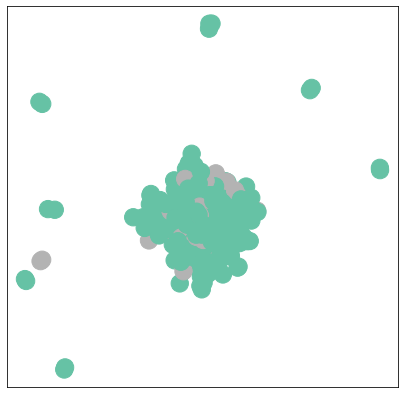

In [45]:
from torch_geometric.utils import to_networkx
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt


def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

network = to_networkx(data, to_undirected=True)
visualize(network, color=data.x)

In [11]:
## Task 5 (Edge_Index)

pattern = re.compile(r'(match[0-9]+).html')

edge_index = pd.DataFrame([], columns=['nodeid', 'mission', 'moss_ranking', 'edge_weights'])
for name in tqdm(all_names):
    idee = name_to_ID[name]
    relevant_rows = moss_data[(moss_data.name1 == name) | (moss_data.name2 == name)]
    for index, item in relevant_rows.iterrows():
        edge_index = edge_index.append({'nodeid': idee, 
                                        'mission': item.mission, 
                                        'moss_ranking': pattern.search(item.url)[0][5:-5], 
                                        }, ignore_index=True)

100%|██████████| 1032/1032 [00:25<00:00, 40.38it/s]
